In [1]:
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
import pickle
from torchvision import transforms
import pytorch_lightning as pl
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm   

# load own code
import sys
sys.path.append('/home/moritz/Desktop/programming/epilepsy_project/')
from librarys.event.model.model import FineTuning
from librarys.event.datasets import SpikeDataset
from librarys.general.channel_lists import CDAC_mono_channels
from librarys.general.montages import build_montagev2
from librarys.event.transforms import cut_and_jitter,delete_channels
# this holds all the configuration parameters
from librarys.event.model.config import Config
from spike_deletion_v2.spike_deletion_library import DeletedChannelsDatamodule

In [5]:
path_model = '/home/moritz/Desktop/programming/epilepsy_project/spike_deletion_v3/model_zoo/random_deleted_channels'
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)

In [7]:
# load dataset
path_signal = '/media/moritz/a80fe7e6-2bb9-4818-8add-17fb9bb673e1/Data/Bonobo/cluster_center/'
df = pd.read_csv('/home/moritz/Desktop/programming/epilepsy_project/tables/bonobo/lut_event_23-08-22.csv')# fraction filter
extreme_quality_filter = df['total_votes_received'] >= 8

# test_df = df[frac_filter & mode_filter & extreme_quality_filter].copy()    
# neg = test_df[test_df.fraction_of_yes<0.5]         
# pos = test_df[test_df.fraction_of_yes>0.5][:len(neg)]
# test_df = pd.concat([neg,pos])

pos_auc_df = df[(df.Mode=='Test')&(df['fraction_of_yes'] > 6/8) & extreme_quality_filter]
neg_auc_df = df[(df.Mode=='Test')&(df.fraction_of_yes<=1/8)][:len(pos_auc_df)]
test_df = pd.concat([pos_auc_df,neg_auc_df])

In [8]:
# load pretrained model
model = FineTuning.load_from_checkpoint(path_model+'/weights.ckpt',
                                        lr=config.LR,
                                        head_dropout=config.HEAD_DROPOUT,
                                        n_channels=len(config.CHANNELS),
                                        n_fft=config.N_FFT,
                                        hop_length=config.HOP_LENGTH)
                                    
# init trainer
trainer = pl.Trainer(fast_dev_run=False,enable_progress_bar=False,devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
montage = build_montagev2(storage_channels=CDAC_mono_channels,montage_channels=config.CHANNELS)

storage channels: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']
montage channels: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']


# delete n random channels

In [10]:
results = {'n_keeper':[],'run':[],'AUC':[]} # store results here

# get labels and convert them to binary labels (0.1 -> 0, 0.9 -> 1)
labels = test_df.fraction_of_yes.round(0).astype(int)

for n_keeper in tqdm(range(0,len(config.CHANNELS)+1)):
    print(f'Running for {n_keeper} kept channels')
    datamodule = DeletedChannelsDatamodule(path_data=path_signal,df=test_df,model_config=config,storage_channels=CDAC_mono_channels,n_keeper_channels=n_keeper,keeper_channels='random',echo=False)
    # predict on AUC dataset n times, as channel deletion is random
    for run in range(5):
        preds = trainer.predict(model,datamodule.test_dataloader())
        preds = np.concatenate(preds)
        
        fpr, tpr, thresholds = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)

        results['n_keeper'].append(n_keeper)
        results['run'].append(run)
        results['AUC'].append(roc_auc)

  0%|          | 0/20 [00:00<?, ?it/s]You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/moritz/Desktop/programming/epilepsy_project/spike_deletion_v3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 0 kept channels
keeping 0 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
  5%|▌         | 1/20 [00:09<03:06,  9.83s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 1 kept channels
keeping 1 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 10%|█         | 2/20 [00:19<02:56,  9.79s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 2 kept channels
keeping 2 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 15%|█▌        | 3/20 [00:29<02:45,  9.75s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 3 kept channels
keeping 3 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 20%|██        | 4/20 [00:39<02:36,  9.78s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 4 kept channels
keeping 4 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 25%|██▌       | 5/20 [00:48<02:26,  9.79s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 5 kept channels
keeping 5 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 30%|███       | 6/20 [00:58<02:17,  9.83s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 6 kept channels
keeping 6 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 35%|███▌      | 7/20 [01:08<02:08,  9.91s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 7 kept channels
keeping 7 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 40%|████      | 8/20 [01:18<01:59,  9.93s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 8 kept channels
keeping 8 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 45%|████▌     | 9/20 [01:28<01:49,  9.94s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 9 kept channels
keeping 9 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 50%|█████     | 10/20 [01:38<01:39,  9.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 10 kept channels
keeping 10 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 55%|█████▌    | 11/20 [01:48<01:29,  9.99s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 11 kept channels
keeping 11 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 60%|██████    | 12/20 [01:59<01:20, 10.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 12 kept channels
keeping 12 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 65%|██████▌   | 13/20 [02:09<01:10, 10.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 13 kept channels
keeping 13 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 70%|███████   | 14/20 [02:19<01:00, 10.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 14 kept channels
keeping 14 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 75%|███████▌  | 15/20 [02:29<00:50, 10.06s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 15 kept channels
keeping 15 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 80%|████████  | 16/20 [02:39<00:40, 10.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 16 kept channels
keeping 16 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 85%|████████▌ | 17/20 [02:49<00:30, 10.12s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 17 kept channels
keeping 17 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 90%|█████████ | 18/20 [02:59<00:20, 10.12s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 18 kept channels
keeping 18 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
 95%|█████████▌| 19/20 [03:09<00:10, 10.08s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running for 19 kept channels
keeping 19 random channels



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
100%|██████████| 20/20 [03:19<00:00,  9.99s/it]


In [15]:
deletion_results = pd.DataFrame(results)
deletion_results.to_csv(path_model+'/results/deletion_results.csv',index=False)

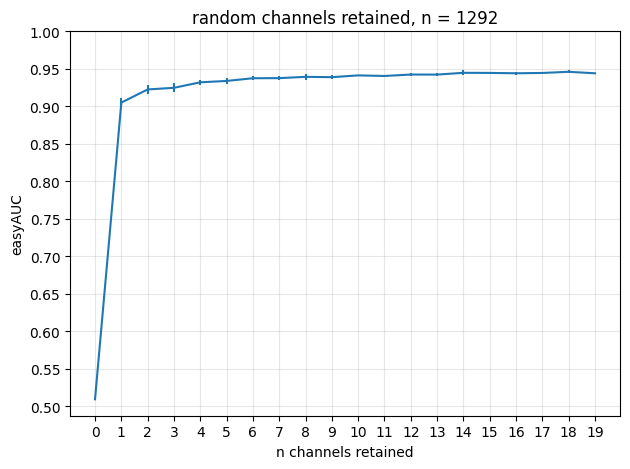

In [12]:
auc_value = pd.DataFrame(results).groupby('n_keeper')['AUC'].mean()
err = pd.DataFrame(results).groupby('n_keeper')['AUC'].std()
# plt.plot(range(0,20),auc)
plt.errorbar(range(0,20),auc_value,yerr=err)
plt.xticks(range(0,20))
plt.yticks(np.arange(0.5,1.01,1/20))
plt.tight_layout()
plt.ylabel('easyAUC')
plt.xlabel('n channels retained')
plt.title(f'random channels retained, n = {len(test_df)}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(path_model+'/results/deletion_result_plot.png')